In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
#from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [4]:
# For reproducibility purposes
np.random.seed(42)

In [5]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [6]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda y: librosa.feature.melspectrogram(y=y, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))


In [7]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    #song_samples = 660000
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [8]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        temp_file_list = os.listdir(folder)
        for file in temp_file_list:
          file_name = folder + "/" + file
          arr_fn.append(file_name)
          arr_genres.append(genres[x])
          
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [9]:
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# gtzan_dir = '/content/drive/MyDrive/Music_Genre_Classification/data/genres/'          

# Prjwal's computer 
gtzan_dir = '/home/bhuyan2/ECE_539/data/genres/'

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(27261, 128, 129, 1) (11700, 128, 129, 1) (27261, 10) (11700, 10)


In [11]:
from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)
            
            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=3)
                cols = np.random.randint(signal.shape[0], size=4)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

In [12]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [13]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [14]:
def ResNet50(input_shape,num_genres):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dropout(0.35)(X)
    X = Dense(256, activation='relu', 
               kernel_regularizer=tf.keras.regularizers.l2(0.02))(X)
    X = Dropout(0.25)(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = Dense(128, activation='relu', 
               kernel_regularizer=tf.keras.regularizers.l2(0.02))(X)
    X = Dropout(0.25)(X)
    X = tf.keras.layers.BatchNormalization()(X)

    X = Dense(64, activation='relu', 
               kernel_regularizer=tf.keras.regularizers.l2(0.02))(X)
    X = Dropout(0.25)(X)
    X = tf.keras.layers.BatchNormalization()(X)

    predictions = Dense(num_genres, 
                         activation='softmax', 
                         kernel_regularizer=tf.keras.regularizers.l2(0.02))(X)
    model = Model(inputs=X_input, outputs=predictions, name='ResNet50')

    return model

In [15]:
#base_model = ResNet50(input_shape=(128, 129, 1))
#model = ResNet50(X_train[0].shape, len(genres))
model = ResNet50(X_train[0].shape, len(genres))

2023-05-02 11:38:43.034090: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 129, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 135, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 65, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 64, 65, 64)   256         ['conv1[0][0]']           

 res2c_branch2c (Conv2D)        (None, 31, 32, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 31, 32, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 31, 32, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 31, 32, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 res3a_bra

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 16, 16, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 16, 16, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 16, 16, 128)  512        ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_19 (Activation)     (None, 16, 16, 128)  0           ['bn3d_branch2a[0][0]']          
          

 bn4c_branch2a (BatchNormalizat  (None, 8, 8, 256)   1024        ['res4c_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_28 (Activation)     (None, 8, 8, 256)    0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_branch2b (Conv2D)        (None, 8, 8, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 bn4c_branch2b (BatchNormalizat  (None, 8, 8, 256)   1024        ['res4c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activatio

                                                                                                  
 res4f_branch2c (Conv2D)        (None, 8, 8, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, 8, 8, 1024)  4096        ['res4f_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_12 (Add)                   (None, 8, 8, 1024)   0           ['bn4f_branch2c[0][0]',          
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 8, 8, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 4, 4, 2048)   0           ['bn5c_branch2c[0][0]',          
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 4, 4, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 2, 2, 2048)  0           ['activation_48[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten (Flatten)              (None, 8192)         0           ['average_pooling2d[0][0]']      
                                                                                                  
 dropout (

In [17]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
              metrics=['accuracy'])

In [18]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8,
    patience=10,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-6
)

In [19]:
# Generators
batch_size = 64
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

In [20]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=400,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/400


/tmp/ipykernel_2115380/3176881705.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


426/426 [==============================] - 436s 988ms/step - loss: 4.4138 - accuracy: 0.1394 - val_loss: 4.2282 - val_accuracy: 0.1819 - lr: 0.0050
Epoch 2/400
426/426 [==============================] - 420s 985ms/step - loss: 3.0485 - accuracy: 0.1469 - val_loss: 2.7593 - val_accuracy: 0.1816 - lr: 0.0050
Epoch 3/400
426/426 [==============================] - 420s 985ms/step - loss: 2.9648 - accuracy: 0.1564 - val_loss: 2.3977 - val_accuracy: 0.1564 - lr: 0.0050
Epoch 4/400
426/426 [==============================] - 418s 982ms/step - loss: 2.8711 - accuracy: 0.1468 - val_loss: 3.9822 - val_accuracy: 0.1830 - lr: 0.0050
Epoch 5/400
426/426 [==============================] - 419s 985ms/step - loss: 2.9902 - accuracy: 0.1398 - val_loss: 2.5795 - val_accuracy: 0.1495 - lr: 0.0050
Epoch 6/400
426/426 [==============================] - 418s 982ms/step - loss: 2.9213 - accuracy: 0.1441 - val_loss: 2.6206 - val_accuracy: 0.1976 - lr: 0.0050
Epoch 7/400
426/426 [==============================]

426/426 [==============================] - 420s 987ms/step - loss: 2.2666 - accuracy: 0.1637 - val_loss: 2.2094 - val_accuracy: 0.2035 - lr: 0.0026
Epoch 50/400
426/426 [==============================] - 419s 983ms/step - loss: 2.2755 - accuracy: 0.1603 - val_loss: 2.1631 - val_accuracy: 0.1919 - lr: 0.0026
Epoch 51/400
426/426 [==============================] - 423s 993ms/step - loss: 2.2651 - accuracy: 0.1565 - val_loss: 2.1959 - val_accuracy: 0.1533 - lr: 0.0026
Epoch 52/400
426/426 [==============================] - 422s 991ms/step - loss: 2.2696 - accuracy: 0.1620 - val_loss: 2.1479 - val_accuracy: 0.1843 - lr: 0.0026
Epoch 53/400
426/426 [==============================] - 427s 1s/step - loss: 2.3015 - accuracy: 0.1547 - val_loss: 2.1916 - val_accuracy: 0.2020 - lr: 0.0026
Epoch 54/400
426/426 [==============================] - 443s 1s/step - loss: 2.2837 - accuracy: 0.1610 - val_loss: 2.1470 - val_accuracy: 0.2130 - lr: 0.0026
Epoch 55/400
426/426 [==============================]

426/426 [==============================] - 418s 981ms/step - loss: 2.0814 - accuracy: 0.2137 - val_loss: 2.3522 - val_accuracy: 0.1015 - lr: 0.0013
Epoch 98/400
426/426 [==============================] - 417s 980ms/step - loss: 2.0976 - accuracy: 0.2092 - val_loss: 2.3497 - val_accuracy: 0.1007 - lr: 0.0013
Epoch 99/400
426/426 [==============================] - 416s 978ms/step - loss: 2.0812 - accuracy: 0.2159 - val_loss: 2.3812 - val_accuracy: 0.1004 - lr: 0.0013
Epoch 100/400
426/426 [==============================] - 418s 981ms/step - loss: 2.0798 - accuracy: 0.2195 - val_loss: 2.3444 - val_accuracy: 0.1003 - lr: 0.0013
Epoch 101/400
426/426 [==============================] - 417s 979ms/step - loss: 2.0905 - accuracy: 0.2115 - val_loss: 2.3451 - val_accuracy: 0.1000 - lr: 0.0013
Epoch 102/400
426/426 [==============================] - 418s 981ms/step - loss: 2.0917 - accuracy: 0.2171 - val_loss: 2.2469 - val_accuracy: 0.1509 - lr: 0.0013
Epoch 103/400
426/426 [=====================

Epoch 143/400
426/426 [==============================] - 418s 981ms/step - loss: 1.9718 - accuracy: 0.2366 - val_loss: 2.4025 - val_accuracy: 0.1015 - lr: 5.3687e-04
Epoch 144/400
426/426 [==============================] - 417s 980ms/step - loss: 1.9797 - accuracy: 0.2316 - val_loss: 2.4653 - val_accuracy: 0.1000 - lr: 5.3687e-04
Epoch 145/400
426/426 [==============================] - 416s 977ms/step - loss: 1.9689 - accuracy: 0.2336 - val_loss: 2.4122 - val_accuracy: 0.1022 - lr: 5.3687e-04
Epoch 146/400
426/426 [==============================] - 418s 980ms/step - loss: 1.9684 - accuracy: 0.2297 - val_loss: 2.3920 - val_accuracy: 0.1058 - lr: 5.3687e-04
Epoch 147/400
426/426 [==============================] - 417s 979ms/step - loss: 1.9702 - accuracy: 0.2383 - val_loss: 2.4206 - val_accuracy: 0.1000 - lr: 5.3687e-04
Epoch 148/400
426/426 [==============================] - ETA: 0s - loss: 1.9626 - accuracy: 0.2356
Epoch 148: ReduceLROnPlateau reducing learning rate to 0.00042949668131

426/426 [==============================] - 416s 976ms/step - loss: 1.9314 - accuracy: 0.2391 - val_loss: 2.4551 - val_accuracy: 0.1000 - lr: 2.1990e-04
Epoch 189/400
426/426 [==============================] - 415s 975ms/step - loss: 1.9339 - accuracy: 0.2431 - val_loss: 2.4853 - val_accuracy: 0.1000 - lr: 2.1990e-04
Epoch 190/400
426/426 [==============================] - 417s 979ms/step - loss: 1.9284 - accuracy: 0.2370 - val_loss: 2.4990 - val_accuracy: 0.1000 - lr: 2.1990e-04
Epoch 191/400
426/426 [==============================] - 416s 976ms/step - loss: 1.9339 - accuracy: 0.2419 - val_loss: 2.4519 - val_accuracy: 0.1001 - lr: 2.1990e-04
Epoch 192/400
426/426 [==============================] - ETA: 0s - loss: 1.9285 - accuracy: 0.2429
Epoch 192: ReduceLROnPlateau reducing learning rate to 0.00017592184012755753.
426/426 [==============================] - 415s 974ms/step - loss: 1.9285 - accuracy: 0.2429 - val_loss: 2.4680 - val_accuracy: 0.1000 - lr: 2.1990e-04
Epoch 193/400
426/42

426/426 [==============================] - 415s 974ms/step - loss: 1.9099 - accuracy: 0.2489 - val_loss: 2.4846 - val_accuracy: 0.1000 - lr: 9.0072e-05
Epoch 234/400
426/426 [==============================] - 415s 975ms/step - loss: 1.9051 - accuracy: 0.2415 - val_loss: 2.4728 - val_accuracy: 0.1000 - lr: 9.0072e-05
Epoch 235/400
426/426 [==============================] - 416s 976ms/step - loss: 1.9036 - accuracy: 0.2531 - val_loss: 2.4979 - val_accuracy: 0.1000 - lr: 9.0072e-05
Epoch 236/400
426/426 [==============================] - ETA: 0s - loss: 1.9058 - accuracy: 0.2493
Epoch 236: ReduceLROnPlateau reducing learning rate to 7.205759175121784e-05.
426/426 [==============================] - 416s 977ms/step - loss: 1.9058 - accuracy: 0.2493 - val_loss: 2.5502 - val_accuracy: 0.1000 - lr: 9.0072e-05
Epoch 237/400
426/426 [==============================] - 417s 979ms/step - loss: 1.9029 - accuracy: 0.2529 - val_loss: 2.5192 - val_accuracy: 0.1000 - lr: 7.2058e-05
Epoch 238/400
426/426

Epoch 279/400
426/426 [==============================] - 414s 973ms/step - loss: 1.8938 - accuracy: 0.2511 - val_loss: 2.5266 - val_accuracy: 0.1000 - lr: 3.6893e-05
Epoch 280/400
426/426 [==============================] - ETA: 0s - loss: 1.8915 - accuracy: 0.2545
Epoch 280: ReduceLROnPlateau reducing learning rate to 2.9514791094698012e-05.
426/426 [==============================] - 415s 975ms/step - loss: 1.8915 - accuracy: 0.2545 - val_loss: 2.5234 - val_accuracy: 0.1000 - lr: 3.6893e-05
Epoch 281/400
426/426 [==============================] - 415s 975ms/step - loss: 1.8957 - accuracy: 0.2516 - val_loss: 2.4670 - val_accuracy: 0.1000 - lr: 2.9515e-05
Epoch 282/400
426/426 [==============================] - 414s 972ms/step - loss: 1.8911 - accuracy: 0.2510 - val_loss: 2.4850 - val_accuracy: 0.1000 - lr: 2.9515e-05
Epoch 283/400
426/426 [==============================] - 415s 976ms/step - loss: 1.8922 - accuracy: 0.2586 - val_loss: 2.4877 - val_accuracy: 0.1000 - lr: 2.9515e-05
Epoch 

426/426 [==============================] - ETA: 0s - loss: 1.8883 - accuracy: 0.2518
Epoch 324: ReduceLROnPlateau reducing learning rate to 1.2089258234482259e-05.
426/426 [==============================] - 414s 971ms/step - loss: 1.8883 - accuracy: 0.2518 - val_loss: 2.5184 - val_accuracy: 0.1000 - lr: 1.5112e-05
Epoch 325/400
426/426 [==============================] - 419s 984ms/step - loss: 1.8868 - accuracy: 0.2526 - val_loss: 2.5241 - val_accuracy: 0.1000 - lr: 1.2089e-05
Epoch 326/400
426/426 [==============================] - 435s 1s/step - loss: 1.8891 - accuracy: 0.2497 - val_loss: 2.5188 - val_accuracy: 0.1000 - lr: 1.2089e-05
Epoch 327/400
426/426 [==============================] - 455s 1s/step - loss: 1.8891 - accuracy: 0.2531 - val_loss: 2.5459 - val_accuracy: 0.1000 - lr: 1.2089e-05
Epoch 328/400
426/426 [==============================] - 454s 1s/step - loss: 1.8870 - accuracy: 0.2487 - val_loss: 2.4965 - val_accuracy: 0.1000 - lr: 1.2089e-05
Epoch 329/400
426/426 [======

426/426 [==============================] - 456s 1s/step - loss: 1.8892 - accuracy: 0.2497 - val_loss: 2.4752 - val_accuracy: 0.1000 - lr: 4.9518e-06
Epoch 370/400
426/426 [==============================] - 454s 1s/step - loss: 1.8912 - accuracy: 0.2527 - val_loss: 2.5742 - val_accuracy: 0.1000 - lr: 4.9518e-06
Epoch 371/400
426/426 [==============================] - 454s 1s/step - loss: 1.8908 - accuracy: 0.2512 - val_loss: 2.4980 - val_accuracy: 0.1000 - lr: 4.9518e-06
Epoch 372/400
426/426 [==============================] - 455s 1s/step - loss: 1.8863 - accuracy: 0.2548 - val_loss: 2.5505 - val_accuracy: 0.1000 - lr: 4.9518e-06
Epoch 373/400
426/426 [==============================] - 455s 1s/step - loss: 1.8839 - accuracy: 0.2582 - val_loss: 2.5314 - val_accuracy: 0.1000 - lr: 4.9518e-06
Epoch 374/400
426/426 [==============================] - 454s 1s/step - loss: 1.8858 - accuracy: 0.2526 - val_loss: 2.4784 - val_accuracy: 0.1000 - lr: 4.9518e-06
Epoch 375/400
426/426 [=============

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))


val_loss = 2.524 and val_acc = 0.100


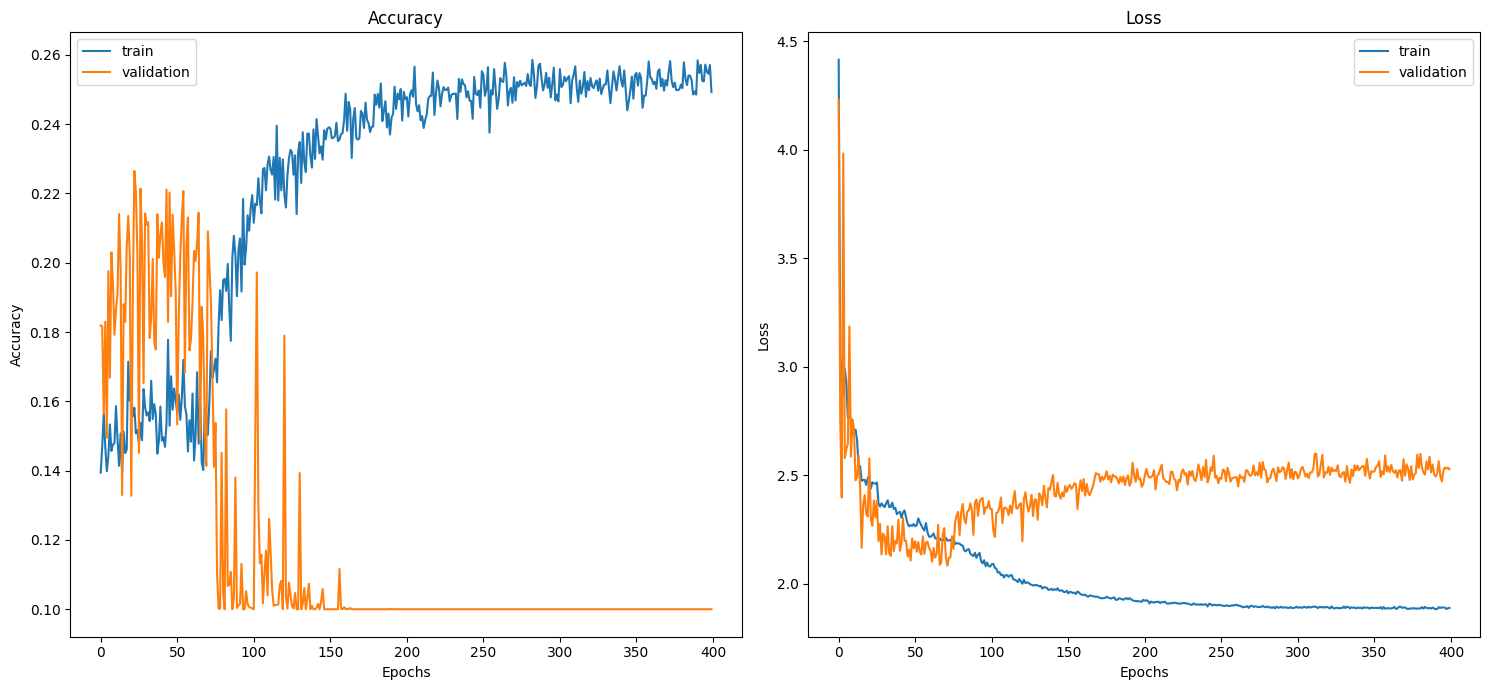

In [22]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

366/366 [==============================] - 61s 165ms/step


/tmp/ipykernel_2115380/824455713.py:10: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Normalized confusion matrix


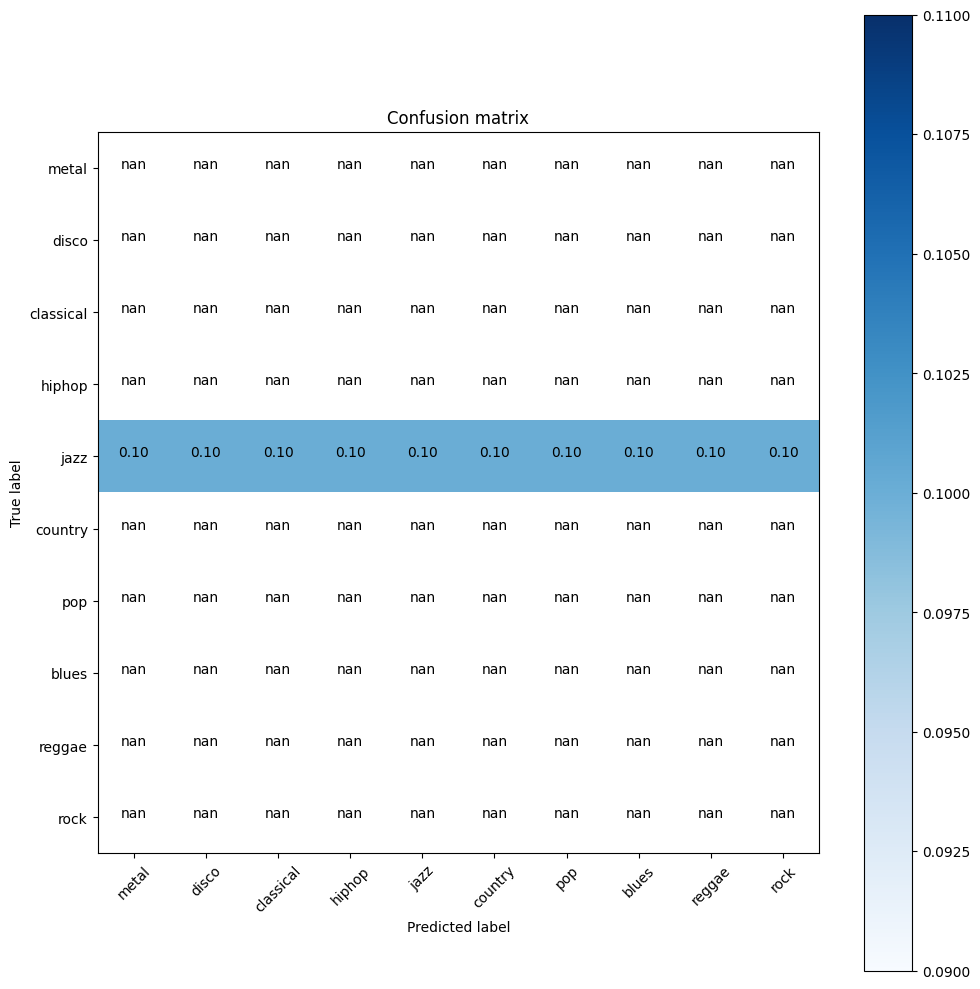

In [25]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)